# Simple epicenter problem

This notebook illustrates a simple method for estimating the horizontal coordinates of an epicenter.

## Geophysical problem

An earthquake generates seismic waves that propagate in the subsusface and are detected by three of seismic stations, A, B and C (green triangles), located on the Earth's surface.

<img src='epicenter_figs\fig1.png', width=700>

Let's consider that, at each station, there is a measure of the difference between the first arrivals of the P and S waves.

<img src='epicenter_figs\fig2.png', width=700>

We may then group these measurements in a vector as follows:

$$
\mathbf{d} = \begin{bmatrix}
\Delta t_{A} \\
\Delta t_{B} \\
\Delta t_{C}
\end{bmatrix} \: ,
$$

where $\Delta t_{i}$ represents the observed time difference between the first arrivals of the P and S waves at the station $i$, $i = A, B, C$. This vector is called **observed data vector**.

## Parameterization and forward problem

By considering that (i) the ray paths can be approximated by straight lines, (ii) the depth of the hypocenter can be negleted and also that (iii) the crust is homogeneous and isotropic, we can define a time difference $\Delta t_{i}$, $i = A, B, C$, as a function of the:

* seismic velocities $v_{P}$ and $v_{S}$;

* station coordinates $x_{i}$ and $y_{i}$, $i = A, B, C$;

* epicenter coordinates $x_{0}$ and $y_{0}$.

Here, we consider a Cartesian coordinate system in which $x$ points to North, $y$ points to East and $z$ points to the subsurface.

In this case, the time differences can be written as follows:

$$
\Delta t_{i} (\mathbf{p}) = \alpha \,
\left[ \left( x_{i} - x_{0} \right)^{2} + \left( y_{i} - y_{0} \right)^{2} \right]^{\frac{1}{2}} \: , \quad i = A, B, C \: ,
$$

where

$$
\mathbf{p} = 
\left[ \begin{array}{c}
x_{0} \\
y_{0}
\end{array} \right]
$$

contains the parameters to be estimated (**parameter vector**) and

$$
\alpha = \frac{1}{v_{S}} - \frac{1}{v_{P}} \: .
$$

From these equations, we obtain a **predicted data vector** given by:

$$
\mathbf{\Delta t}(\mathbf{p}) =
\alpha \, \left[ \begin{array}{c}
\Delta t_{A} (\mathbf{p}) \\
\Delta t_{B} (\mathbf{p}) \\
\Delta t_{C} (\mathbf{p})
\end{array} \right] \: .
$$

## Goal function

Given the observed data vector $\mathbf{d}$, the coordinates of the stations, and the seismic velocities $v_{P}$ and $v_{S}$, we can determine the coordinates of the epicenter by estimating the particular parameter vector $\mathbf{p}^{\ast}$ minimizing the goal function:

$$
\Phi(\mathbf{p}) = \left[ \mathbf{d} - \mathbf{\Delta t}(\mathbf{p}) \right]^{\, \top}\left[ \mathbf{d} - \mathbf{\Delta t}(\mathbf{p}) \right] \: .
$$

Note that, differently from a linear problem (e.g., the problems presented in the notebooks [least_squares](https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/least_squares.ipynb) and [grav_net](https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/grav_net.ipynb)), the derivative of the predicted data $\Delta t_{i} (\mathbf{p})$, $i = A, B, C$, with respect to $x_{0}$ or $y_{0}$ is still a function of $x_{0}$ and $y_{0}$. Consequently, setting the gradient of $\Phi(\mathbf{p})$ to the null vector does not result in a linear system for estimating $\mathbf{p}^{\ast}$. The problem of estimating $\mathbf{p}^{\ast}$ is an example of non-linear optimization problem and needs to be solved iteratively.

## Synthetic data

<a id='Auxiliary functions'></a>
#### Auxiliary functions

In [1]:
def predicted_data(vp,vs,x,y,p):
    '''
    Computes the predicted data.
    
    input
    vp, vs: floats - seismic velocities
    x, y: numpy arrays - coordinates x and y of the stations
    p: numpy array - parameter vector
    
    output
    dt: numpy array - predicted data
    '''
    
    if vp <= vs:
        raise ValueError('vp must be greater than vs')
    
    if x.size != y.size:
        raise ValueError('x and y must have the same number of elements')
    
    if (vp != 0.) & (vs != 0.):
        alfa = 1./vs - 1./vp
    else:
        raise ValueError('vp and vs must be non-null')
    
    # predicted data
    dt = alfa*np.sqrt((x - p[0])**2 + (y - p[1])**2)
    
    return dt

In [2]:
def plot_data(data, filename=None):
    '''
    input
    data: list of numpy arrays - data sets to be plotted.
          In the case of two data sets, the first 
          one must be the observed data.
    filename: string or None - if not None, it saves the figure with
              name defined by filename.
   
    output
    matplotlib figure
    '''

    assert (len(data) == 1) or (len(data) == 2), \
'must use one or two data sets'

    plt.figure(figsize=(8,3))
    stations_label = ['A', 'B', 'C']
    stations = [1,2,3]
    
    if len(data) == 1:
        plt.barh(stations, data[0], align='center', 
             color='r', alpha=1, label='Observed')
    if len(data) == 2:
        plt.barh(stations, data[0], align='center', 
                 color='r', alpha=0.6, label='Observed')
        plt.barh(stations, data[1], align='center', 
                 fill=False, edgecolor='b', alpha=1.,
                 linewidth=3., linestyle='dashed', label='Predicted')
    plt.yticks(stations, stations_label, fontsize=18)
    plt.xticks(fontsize=14)
    plt.xlabel('$\Delta t$ ($s$)', fontsize=18)
    plt.ylabel('Stations', fontsize=16)
    plt.grid()
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
               loc=3, ncol=2, borderaxespad=0.)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [3]:
def goal_function_grid(dobs,vp,vs,x,y,x0,y0):
    '''
    Computes the goal function in a grid of
    parameters x0 and y0.
    
    input
    dobs: numpy array - observed data
    vp, vs: floats - seismic velocities
    x, y: numpy arrays - coordinates x and y of the stations
    
    output
    phi: numpy array - grid of goal function values
    '''
    
    if vp <= vs:
        raise ValueError('vp must be greater than vs')
    
    if x.size != y.size:
        raise ValueError('x and y must have the same number of elements')
    
    if (vp != 0.) & (vs != 0.):
        alfa = 1./vs - 1./vp
    else:
        raise ValueError('vp and vs must be non-null')
   
    phi = np.zeros_like(x0)
    for x, y, dt in zip(x, y, dobs):
        phi += (dt - alfa*np.sqrt((x - x0)**2 + (y - y0)**2))**2
    return phi

In [4]:
def convergence(phi0,phi,beta):
    '''
    Evaluate the convergence criterion.
    '''

    # relative variation
    rel_variation = abs((phi0-phi)/phi0)
    
    return rel_variation < beta

In [5]:
def plot_goal_function(x0, y0, phi, p_true=None, stations=None, epicenters=None, 
                       filename=None):
    '''
    Plot the goal function, the stations, the true epicenter
    location and the set of estimated epicenters produced by
    an iterative method.
    
    input
    x0, y0: numpy arrays 2D - grid of epicenter coordinates
            on which the goal function is evaluated
    phi: numpy array 2D - grid of goal function values
    p_true: None or numpy array 1D containing the true coordinates
            of the epicenter
    stations: numpy array 2D - matrix containing the coordinates of
              the stations. The first collumn contains the
                x coordinate and the second collumn contains the y coordinate
                of the stations.
    epicenters: numpy array 2D - matrix containing the estimated coordinates
                computed by an iterative method. The first collumn contains the
                x coordinate and the second collumn contains the y coordinate
                of the estimated epicenters.
    filename: string or None - if not None, it saves the figure with
              name defined by filename
    
    output
    matplotlib figure
    '''
    
    if p_true is not None:
        assert p_true.size == 2, 'p_true must have 2 elements'
    if stations is not None:
        assert (stations.shape[1] == 2), 'stations must have 2 collumns'
        assert (stations.shape[0] >= 3), \
'the number of stations must be greater than or equal to 3'

    xmax = np.max(x0)
    xmin = np.min(x0)
    
    ymax = np.max(y0)
    ymin = np.min(y0)
    
    plt.figure(figsize=(8,6))
    plt.axis('scaled')
    plt.contourf(y0,x0,phi,40, cmap = plt.get_cmap('viridis'))
    cbar = plt.colorbar()
    cbar.set_label('$\Delta t$ ($s$)', fontsize=16)
    if stations is not None:
        plt.plot(stations[:,1], stations[:,0],'k^', markersize=14)
    if p_true is not None:
        plt.plot([p_true[1]], [p_true[0]], 'ro', markersize=14)
    if epicenters is not None:
        plt.plot(epicenters[:,1],epicenters[:,0],'w-', linewidth=1)
        plt.plot(epicenters[:,1],epicenters[:,0],'wo', markersize=6)
    plt.xlabel('y (km)', fontsize=14)
    plt.ylabel('x (km)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(ymin,ymax)
    plt.ylim(xmin,xmax)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [6]:
def plot_phi(phi, filename=None):
    '''
    Plot the goal function values along the
    iterations.
    
    input
    phi: list - goal function values
    filename: string or None - if not None, it saves the figure with
              name defined by filename
    
    output
    matplotlib figure
    '''
    
    it = [i for i in range(len(phi))]
    plt.figure(figsize=(8,8))
    plt.plot(it,phi,'ko')
    plt.plot(it,phi,'k-')
    plt.xlabel('$k$', fontsize=18)
    plt.ylabel('$\phi(\mathbf{p})$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.xlim(0, len(phi))
    plt.ylim(-5.,phi[0]+5.)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

#### Import the required packages

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

#### Limits of the simulated study area

In [8]:
# limits of the study area in km
xmin = 0.
xmax = 100.
ymin = -50.
ymax = 50.

#### Seismic velocities

In [9]:
# seismic velocities in km/s
vp = 6.5
vs = 6.5/1.6

#### Coordinates of the epicenter

In [10]:
# coordinates of the simulated epicenter in km
p_true = np.array([50., -17.])

#### Coordinates of the seismic stations

In [11]:
# coordinates of the seismic stations in km
x = np.array([10., 80., 60.])

y = np.array([-40., -20., 35.])

stations = np.vstack([x, y]).T

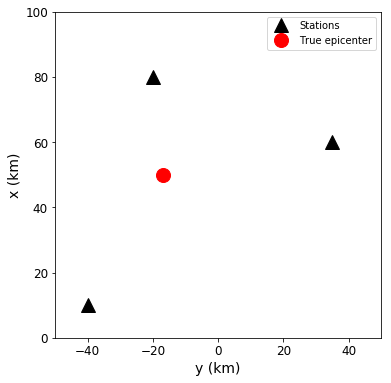

In [12]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.plot(y, x,'k^', markersize=14, label='Stations')
plt.plot([p_true[1]], [p_true[0]], 'ro', markersize=14, label='True epicenter')
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.legend(loc='best', numpoints=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

#### Synthetic data vector

Given the model defined in the previous cells, we can simulate an observed data vector $\mathbf{d}$ by using the function `predicted_data` as follows:

In [13]:
d = predicted_data(vp, vs, x, y, p_true)

#### Goal function

In this example, the goal function depends on two parameters, which represent the Cartesian coordinates of the epicenter. It means that, given a point $(x_{0},y_{0})$, and consequently a parameter vector $\mathbf{p}$, we can calculate the function $\Phi(\mathbf{p})$. Then, if we define a grid of points $(x_{0},y_{0})$, each one representing a possible epicenter, we can calculate the goal function $\Phi(\mathbf{p})$ on a grid.

The grid of points representing possible epicenter can be defined as follows:

In [14]:
# number of points along the x and y axes
Nx = 200
Ny = 200

In [15]:
# grid of Nx by Ny points

x0_grid = np.linspace(xmin, xmax, Nx) # numpy array 1D
y0_grid = np.linspace(ymin, ymax, Ny) # numpy array 1D

# use the numpy arrays 1D to create numpy arrays 2D
x0_grid, y0_grid = np.meshgrid(x0_grid,y0_grid)

In [16]:
phi_grid = goal_function_grid(d,vp,vs,x,y,x0_grid,y0_grid)

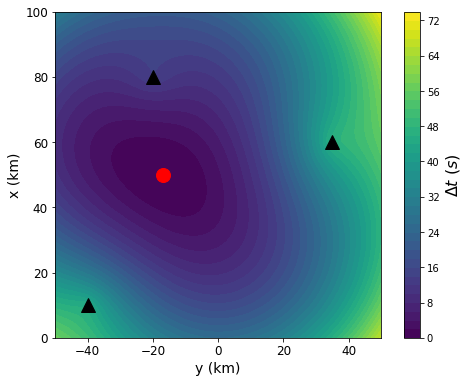

In [17]:
plot_goal_function(x0_grid, y0_grid, phi_grid, 
                   p_true=p_true, stations=stations)

Notice that the minimum of the goal function is located at the point representing the true epicenter (red circle). So, we could use the figure above to estimate the coordinates of the epicenter by choosing the point associated with the minimum value of the goal function.

Another way of estimating the coordinates of the epicenter is using a numerical method. Here, we will limit ourselves to methods based on the gradient of the goal function. Specifically, we will talk about **Newton's**, **Gauss-Newton**, **Steepest Decent**, and **Levenberg-Marquardt** method.

The following cell contains the base algorithm used to implement the **Newton's**, **Gauss-Newton**, **Steepest Decent** method.

    # initial approximation
    p0 = np.array([20., 40.])
    
    # predicted data produced by the initial approximation
    d0 = predicted_data(vp,vs,x,y,p0)
    
    # residual produced by the initial approaximation
    r0 = dobs - d0
    
    # goal function produced by the initial approximation
    phi0 = np.sum(r0*r0)

    # lists used to save the estimated parameters 
    # and goal function values
    x0_list = [p0[0]]
    y0_list = [p0[1]]
    phi_list = [phi0]

    # maximum number of iterations
    itmax = 50
    
    # small value controlling the convergence
    beta = 0.00001

    for it in range(itmax):

        # Jacobian matrix
        G = jacobian()
        
        # gradient
        g = -2.*np.dot(G.T,r0)
        
        # Hessian matrix
        H = hessian()

        # correction on the parameter vector
        dp = linear_system(H,-g)

        # predicte data produced by the new parameter vector p0+dp
        d = predicted_data(vp,vs,x,y,p0+dp)
        
        # residuals produced by the new parameter vector p0+dp
        r = dobs - d
        
        # goal function produced by the new parameter vector p0+dp
        phi = np.sum(r*r)

        # absolute variation in the goal function
        dphi = phi - phi0
        
        # relative variation in the goal function
        rel_variation = abs(dphi)/(phi0 + 1e-15)

        # convengence analysis
        if (dphi > 0) or (rel_variation <= beta):
            # convergence achieved
            break
        else:
            # convengence not achieved
            phi0 = phi
            p0 += dp
            d0 = d
            r0 = r
            x0_list.append(p0[0])
            y0_list.append(p0[1])
            phi_list.append(phi0)

    # predicted data produced by the final estimate
    d = d0
    
    # set of estimated parameters
    epicenters = np.array([x0_list, y0_list]).T

The following cell contains the base algorithm used to implement the **Levenberg-Marquardt** method.

    # initial approximation
    p0 = np.array([20., 40.])
    
    # predicted data produced by the initial approximation
    d0 = predicted_data(vp,vs,x,y,p0)
    
    # residual produced by the initial approaximation
    r0 = dobs - d0
    
    # goal function produced by the initial approximation
    phi0 = np.sum(r0*r0)

    # lists used to save the estimated parameters 
    # and goal function values
    x0_list = [p0[0]]
    y0_list = [p0[1]]
    phi_list = [phi0]

    # maximum number of iterations in the outer loop
    itmax = 50
    
    # small value controlling the convergence
    beta = 0.00001
    
    # Identity matrix
    I = np.identity(2)
    
    # initial value for the levenberg-marquardt parameter
    lamb = 0.1
    
    # positive contant used to change the levenberg-marquardt parameter
    dlamb = 2.
    
    # maximum number of iterations in the inner loop
    itmax_marq = 15

    for it in range(itmax):

        # Jacobian matrix
        G = jacobian()
        
        # gradient
        g = -2.*np.dot(G.T,r0)
        
        # Hessian matrix
        H = hessian()

        # correction on the parameter vector
        dp = linear_system(H,-g)

        # predicte data produced by the new parameter vector p0+dp
        d = predicted_data(vp,vs,x,y,p0+dp)
        
        # residuals produced by the new parameter vector p0+dp
        r = dobs - d
        
        # goal function produced by the new parameter vector p0+dp
        phi = np.sum(r*r)

        # absolute variation in the goal function
        dphi = phi - phi0
        
        # relative variation in the goal function
        rel_variation = abs(dphi)/(phi0 + 1e-15)

        # convengence analysis
        if (dphi > 0) or (rel_variation <= beta):
            # convergence achieved
            break
        else:
            # convengence not achieved
            phi0 = phi
            p0 += dp
            d0 = d
            r0 = r
            x0_list.append(p0[0])
            y0_list.append(p0[1])
            phi_list.append(phi0)

    # predicted data produced by the final estimate
    d = d0
    
    # set of estimated parameters
    epicenters = np.array([x0_list, y0_list]).T

### Exercise

1) In your `my_functions.py` file, create a function for calculating the Jacobian matrix. Your code must look like:

    def jacobian(variable1, variable2, ...):
        '''
        Brief description of this function
        text text text ...

        input
        text text text ...
        text text text ...

        output
        G: numpy array 2D - the Jacobian matrix
        '''

        assert (condition), 'error message'
        assert (condition1) and (condition2), 'error message'
        
        your code your code your code
        your code your code your code
        your code your code your code
        your code your code your code
        
        return G

2) In your `my_functions.py` file, create a function for calculating the true Hessian matrix. Your code must look like:

    def hessian(variable1, variable2, ...):
        '''
        Brief description of this function
        text text text ...

        input
        text text text ...
        text text text ...

        output
        H: numpy array 2D - the Hessian matrix
        '''

        assert (condition), 'error message'
        assert (condition1) and (condition2), 'error message'
        
        your code your code your code
        your code your code your code
        your code your code your code
        your code your code your code
        
        return H

3) In your `test_my_functions.py` file, create a test for the function `jacobian`. The test must compare the Jacobian matrix created by your function and the Jacobian matrix obtained by using known `vp`, `vs`, `x`, `y`, and `p`.

4) In your `test_my_functions.py` file, create a test for the function `hessian`. The test must compare the Hessian matrix created by your function and the Hessian matrix obtained by using known `vp`, `vs`, `x`, `y`, and `p`.

### Exercise (extra)

By using one of your functions for solving linear systems and your functions for computing the Jacobian and Hessian matrices, implement the **Newton's**, **Gauss-Newton**, **Steepest Decent**, and **Levenberg-Marquardt** method.

After estimating the epicenter by using these methods, use the [Auxiliary functions](#Auxiliary functions) to plot the results. The following cells present some results obtained with the Levenberg-Marquardt method:

    plot_goal_function(x0_grid, y0_grid, phi_grid,
                       p_true=p_true, stations=stations, epicenters=epicenters_lm,
                       filename='epicenters_lm.png')

<img src='epicenter_figs/epicenters_lm.png', width=500>

    plot_phi(phi_list_lm, filename='convergence_lm.png')

<img src='epicenter_figs/convergence_lm.png', width=500>

    plot_data([dobs, d_lm], filename='datafit_lm.png')

<img src='epicenter_figs/datafit_lm.png', width=500>